In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm.auto import tqdm
from glob import glob
import time, gc
import cv2
from keras import backend as K
import matplotlib.image as mpimg
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.models import clone_model
from keras.layers import Dense,Conv2D,Flatten,MaxPool2D,Dropout,BatchNormalization,Activation
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import PIL.Image as Image, PIL.ImageDraw as ImageDraw, PIL.ImageFont as ImageFont
from matplotlib import pyplot as plt
import seaborn as sns

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

C:\Users\nguye\Anaconda3\envs\env_python3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
C:\Users\nguye\Anaconda3\envs\env_python3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\nguye\Anaconda3\envs\env_python3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\nguye\Anaco

In [2]:
sample_submission = pd.read_csv("data/sample_submission.csv")
test = pd.read_csv("data/test.csv")
train = pd.read_csv("data/train.csv")

In [3]:
train.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


In [4]:
x = train['image_id']

In [5]:
img_size=80

In [6]:
train_image=[]
for name in train['image_id']:
    path='data/images/'+name+'.jpg'
    img=cv2.imread(path)
    image=cv2.resize(img,(img_size,img_size),interpolation=cv2.INTER_AREA)
    train_image.append(image)

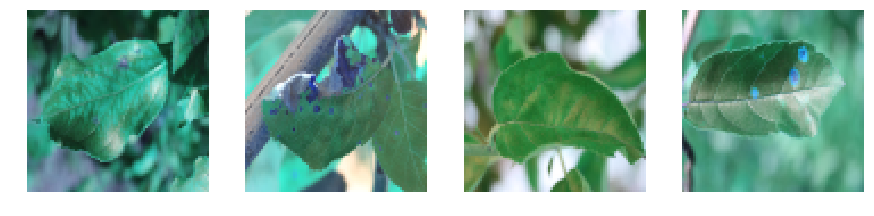

In [7]:
fig, ax = plt.subplots(1, 4, figsize=(15, 15))
for i in range(4):
    ax[i].set_axis_off()
    ax[i].imshow(train_image[i])

In [8]:
test.head()

,image_id
0,Test_0
1,Test_1
2,Test_2
3,Test_3
4,Test_4


In [9]:
test_image=[]
for name in test['image_id']:
    path='data/images/'+name+'.jpg'
    img=cv2.imread(path)
    image=cv2.resize(img,(img_size,img_size),interpolation=cv2.INTER_AREA)
    test_image.append(image)

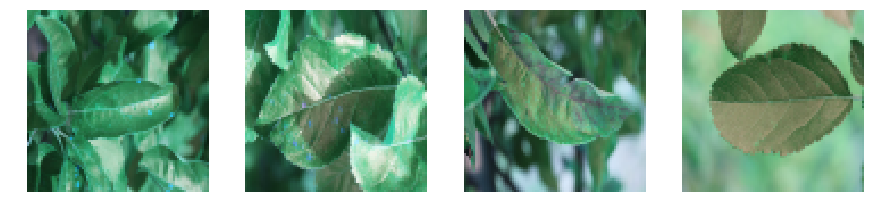

In [10]:
fig, ax = plt.subplots(1, 4, figsize=(15, 15))
for i in range(4):
    ax[i].set_axis_off()
    ax[i].imshow(test_image[i])

In [11]:
#from keras.preprocessing.image import img_to_array
X_Train = np.ndarray(shape=(len(train_image), img_size, img_size, 3),dtype = np.float32)
i=0
for image in train_image:
    #X_Train[i]=img_to_array(image)
    X_Train[i]=train_image[i]
    i=i+1
X_Train=X_Train/255
print('Train Shape: {}'.format(X_Train.shape))

Train Shape: (1821, 80, 80, 3)


In [12]:
X_Test = np.ndarray(shape=(len(test_image), img_size, img_size, 3),dtype = np.float32)
i=0
for image in test_image:
    #X_Test[i]=img_to_array(image)
    X_Test[i]=test_image[i]
    i=i+1
    
X_Test=X_Test/255
print('Test Shape: {}'.format(X_Test.shape))

Test Shape: (1821, 80, 80, 3)


In [13]:
y = train.copy()
del y['image_id']
y.head()

,healthy,multiple_diseases,rust,scab
0,0,0,0,1
1,0,1,0,0
2,1,0,0,0
3,0,0,1,0
4,1,0,0,0


In [14]:
y_train = np.array(y.values)
print(y_train.shape,y_train[0])

(1821, 4) [0 0 0 1]


In [15]:
def construct_model():
    model = Sequential()
    
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', input_shape=(img_size, img_size, 3),
                activation='relu'))
    model.add(BatchNormalization()) # Normalize the activations of the previous layer at each batch
    model.add(MaxPool2D(pool_size=(2, 2)))
    
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu'))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu'))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='SAME', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu'))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='SAME', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
   
    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu'))
    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu'))
    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    
    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu'))
    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu'))
    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='SAME', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu'))
    model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu'))
    model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu'))
    model.add(BatchNormalization())
    
    model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu'))
    model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu'))
    model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='SAME', activation='relu'))
    model.add(BatchNormalization())

    model.add(Flatten()) # Flatten the input
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(4, activation='softmax'))
    # Configure the learning process
    # The loss function is the objective that the model will try to minimize
    # For any classification problem, use accuracy metric
    optimizer = Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    model.summary()
    return model

In [16]:
X_train, X_val, Y_train, Y_val = train_test_split(X_Train, y_train, test_size=0.1, random_state=30)

In [ ]:
model = construct_model()
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)
# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range=360, # Degree range for random rotations
                        width_shift_range=0.2, # Range for random horizontal shifts
                        height_shift_range=0.2, # Range for random vertical shifts
                        zoom_range=0.2, # Range for random zoom
                        horizontal_flip=True, # Randomly flip inputs horizontally
                        vertical_flip=True) # Randomly flip inputs vertically

datagen.fit(X_train)
# Fits the model on batches with real-time data augmentation
hist = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=32),
               steps_per_epoch=X_train.shape[0] // 32,
               epochs=200,
               verbose=1,
               callbacks=[annealer, checkpoint],
               validation_data=(X_val, Y_val))

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 80, 80, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 80, 80, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 40, 40, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 40, 40, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 40, 40, 32)        9248      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 40, 40, 32)        9248      
________________________________________________

Epoch 8/200
51/51 [==============================] - 2s 36ms/step - loss: 1.1735 - accuracy: 0.4533 - val_loss: 1.2739 - val_accuracy: 0.3934

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.0010000000474974513.

Epoch 00008: val_loss improved from 1.27717 to 1.27393, saving model to model.h5
Epoch 9/200
51/51 [==============================] - 2s 39ms/step - loss: 1.1793 - accuracy: 0.4489 - val_loss: 1.2717 - val_accuracy: 0.3934

Epoch 00009: val_loss improved from 1.27393 to 1.27170, saving model to model.h5
Epoch 10/200
51/51 [==============================] - 2s 36ms/step - loss: 1.1734 - accuracy: 0.4620 - val_loss: 1.2611 - val_accuracy: 0.3279

Epoch 00010: val_loss improved from 1.27170 to 1.26109, saving model to model.h5
Epoch 11/200
51/51 [==============================] - 2s 34ms/step - loss: 1.1675 - accuracy: 0.4564 - val_loss: 1.2591 - val_accuracy: 0.3607

Epoch 00011: val_loss improved from 1.26109 to 1.25908, saving model to model.h5
Epoch 12/200
51/51 [=

51/51 [==============================] - 2s 36ms/step - loss: 0.4909 - accuracy: 0.8238 - val_loss: 0.4581 - val_accuracy: 0.8470

Epoch 00047: val_loss improved from 0.48539 to 0.45810, saving model to model.h5
Epoch 48/200
51/51 [==============================] - 2s 35ms/step - loss: 0.4743 - accuracy: 0.8450 - val_loss: 0.6269 - val_accuracy: 0.7923

Epoch 00048: val_loss did not improve from 0.45810
Epoch 49/200
51/51 [==============================] - 2s 37ms/step - loss: 0.4714 - accuracy: 0.8425 - val_loss: 0.5694 - val_accuracy: 0.8033

Epoch 00049: val_loss did not improve from 0.45810
Epoch 50/200
51/51 [==============================] - 2s 36ms/step - loss: 0.4441 - accuracy: 0.8555 - val_loss: 0.6959 - val_accuracy: 0.7705

Epoch 00050: val_loss did not improve from 0.45810
Epoch 51/200
51/51 [==============================] - 2s 36ms/step - loss: 0.5086 - accuracy: 0.8337 - val_loss: 0.7902 - val_accuracy: 0.6885

Epoch 00051: ReduceLROnPlateau reducing learning rate to 0.

51/51 [==============================] - 2s 37ms/step - loss: 0.3195 - accuracy: 0.8977 - val_loss: 0.3958 - val_accuracy: 0.8634

Epoch 00086: val_loss did not improve from 0.28054
Epoch 87/200
51/51 [==============================] - 2s 35ms/step - loss: 0.3456 - accuracy: 0.8823 - val_loss: 0.3558 - val_accuracy: 0.8852

Epoch 00087: val_loss did not improve from 0.28054
Epoch 88/200
51/51 [==============================] - 2s 37ms/step - loss: 0.3150 - accuracy: 0.9032 - val_loss: 0.3442 - val_accuracy: 0.9071

Epoch 00088: val_loss did not improve from 0.28054
Epoch 89/200
51/51 [==============================] - 2s 37ms/step - loss: 0.3003 - accuracy: 0.9085 - val_loss: 0.5805 - val_accuracy: 0.7596

Epoch 00089: ReduceLROnPlateau reducing learning rate to 0.001.

Epoch 00089: val_loss did not improve from 0.28054
Epoch 90/200
51/51 [==============================] - 2s 36ms/step - loss: 0.3047 - accuracy: 0.8966 - val_loss: 0.5159 - val_accuracy: 0.8470

Epoch 00090: val_loss di

51/51 [==============================] - 2s 36ms/step - loss: 0.3640 - accuracy: 0.8835 - val_loss: 0.3039 - val_accuracy: 0.9180

Epoch 00126: val_loss did not improve from 0.23890
Epoch 127/200
51/51 [==============================] - 2s 37ms/step - loss: 0.2799 - accuracy: 0.9105 - val_loss: 0.3554 - val_accuracy: 0.9016

Epoch 00127: ReduceLROnPlateau reducing learning rate to 0.001.

Epoch 00127: val_loss did not improve from 0.23890
Epoch 128/200
51/51 [==============================] - 2s 38ms/step - loss: 0.3004 - accuracy: 0.9078 - val_loss: 0.3433 - val_accuracy: 0.9016

Epoch 00128: val_loss did not improve from 0.23890
Epoch 129/200
51/51 [==============================] - 2s 39ms/step - loss: 0.2541 - accuracy: 0.9196 - val_loss: 0.2286 - val_accuracy: 0.9344

Epoch 00129: val_loss improved from 0.23890 to 0.22859, saving model to model.h5
Epoch 130/200
51/51 [==============================] - 2s 36ms/step - loss: 0.2641 - accuracy: 0.9136 - val_loss: 0.2368 - val_accuracy

51/51 [==============================] - 2s 39ms/step - loss: 0.2258 - accuracy: 0.9167 - val_loss: 0.4447 - val_accuracy: 0.8689

Epoch 00165: val_loss did not improve from 0.21322
Epoch 166/200
51/51 [==============================] - 2s 38ms/step - loss: 0.2790 - accuracy: 0.9184 - val_loss: 0.4452 - val_accuracy: 0.8470

Epoch 00166: val_loss did not improve from 0.21322
Epoch 167/200
51/51 [==============================] - 2s 39ms/step - loss: 0.2806 - accuracy: 0.9066 - val_loss: 0.2261 - val_accuracy: 0.9399

Epoch 00167: val_loss did not improve from 0.21322
Epoch 168/200
51/51 [==============================] - 2s 39ms/step - loss: 0.2286 - accuracy: 0.9284 - val_loss: 0.2240 - val_accuracy: 0.9290

Epoch 00168: ReduceLROnPlateau reducing learning rate to 0.001.

Epoch 00168: val_loss did not improve from 0.21322
Epoch 169/200
51/51 [==============================] - 2s 37ms/step - loss: 0.2346 - accuracy: 0.9234 - val_loss: 0.3496 - val_accuracy: 0.8962

Epoch 00169: val_los

In [ ]:
predict = model.predict(X_Test)
all_predict = np.ndarray(shape = (test.shape[0],4),dtype = np.float32)
for i in range(0,test.shape[0]):
    for j in range(0,4):
        if predict[i][j]==max(predict[i]):
            all_predict[i][j] = 1
        else:
            all_predict[i][j] = 0 

In [ ]:
healthy = [y_test[0] for y_test in all_predict]
multiple_diseases = [y_test[1] for y_test in all_predict]
rust = [y_test[2] for y_test in all_predict]
scab = [y_test[3] for y_test in all_predict]

In [ ]:
df = {'image_id':test.image_id,'healthy':healthy,'multiple_diseases':multiple_diseases,'rust':rust,'scab':scab}

In [ ]:
data = pd.DataFrame(df)
data.tail()

In [ ]:
data.to_csv('submission.csv',index = False)